# Ridge/Lasso Regression

This script fits a ridge and Lasso regression through the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import warnings
import pickle

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [38]:
# Use all data or work on subset?
USE_ALL_DATA = False
WRITE_RESULTS = True
WITH_AIRPORT_CLASSES = False

if WITH_AIRPORT_CLASSES:
    df = pd.read_csv("Data/modified_data_with_classes.csv")
else:
    df = pd.read_csv("Data/modified_training_data_complete.csv")

if not USE_ALL_DATA:
    df = df.sample(n=500000, replace=False)
    df.reset_index(inplace=True, drop=True)

## Get the data ready for analysis

As our machine learning model cannot handle categorical variables, we first encode them into a one-hot encoding. After having encoded these columns, we drop the original ones.

In [39]:
airline_dummies = pd.get_dummies(df['AIRLINE'], prefix = 'AIRLINE')

df = pd.merge(
    left=df,
    right=airline_dummies,
    left_index=True,
    right_index=True,
)

df.drop(columns = ['AIRLINE'], inplace=True)

if WITH_AIRPORT_CLASSES:
    origin_dummies = pd.get_dummies(df['ORIGIN_CLASS'], prefix = "ORIGIN")
    destination_dummies = pd.get_dummies(df['DESTINATION_CLASS'], prefix = "DESTINATION")
    
    df = pd.merge(
        left = df,
        right = origin_dummies,
        left_index = True,
        right_index = True)
    
    df = pd.merge(
        left = df,
        right = destination_dummies,
        left_index = True,
        right_index = True)
    
    df.drop(columns = ['ORIGIN_CLASS', 'DESTINATION_CLASS'], inplace=True)
else:
    or_airport_dummies = pd.get_dummies(df['ORIGIN_AIRPORT'], prefix = 'OR_AIR')
    dest_airport_dummies = pd.get_dummies(df['DESTINATION_AIRPORT'], prefix = 'DEST_AIR')

    df = pd.merge(
        left=df,
        right=or_airport_dummies,
        left_index=True,
        right_index=True,
    )

    df = pd.merge(
        left=df,
        right=dest_airport_dummies,
        left_index=True,
        right_index=True,
    )
    
    df.drop(columns=['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], inplace=True)

df.shape

(500000, 657)

## Fit the regression models

We will fit both a ridge and lasso regression

In [40]:
# Set some useful parameters
TARGET = 'TARGET_3'             # 'TARGET_1', 'TARGET_2', 'TARGET_3' or 'ALL'
COMPONENTS_TO_RETAIN_STEP_SIZE = 5

alpha_to_test = np.power(10,np.arange(-2,2,0.5))
n_features_to_test = np.arange(1, 21, COMPONENTS_TO_RETAIN_STEP_SIZE)

# Create the design matrix (no column of ones in front)
X = df.loc[:, ~df.columns.isin(['SCHEDULED_TIME', 'CANCELLED', 'TARGET_1', 'TARGET_2', 'TARGET_3'])]

pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA()),
        ('regressor', linear_model.Ridge())
        ])

params = [{'reduce_dim' : [PCA()],
          'reduce_dim__n_components': n_features_to_test,
          'regressor__alpha': alpha_to_test,
          'scaler' : [StandardScaler(), RobustScaler()],
          'regressor': [linear_model.Ridge(), linear_model.Lasso()]},
          
          {'reduce_dim' : ["passthrough"],
          'regressor__alpha': alpha_to_test,
          'scaler' : [StandardScaler(), RobustScaler()],
          'regressor': [linear_model.Ridge(), linear_model.Lasso()]}]

# Define penalty function
def MSE(pred, target):
    return (np.square(pred - target)).mean(axis=0)

# Define the function that finds the best model and displays some useful information about it, like goodness-of-fit
# measures, among other thigns.
def find_model_for(target):
    y = df.loc[:, target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    gridsearch = GridSearchCV(pipe, params, verbose=1).fit(X_train, y_train)
    
    print("Model for target variable %s:" % target)
    print("Coefficient of Determination =", gridsearch.score(X_test, y_test))
    print("Mean Squared Error =", MSE(gridsearch.predict(X_test), y_test))
    print(gridsearch.best_params_)
    
    return gridsearch
    
    
if TARGET == 'ALL':
    model1 = find_model_for('TARGET_1')
    model2 = find_model_for('TARGET_2')
    model3 = find_model_for('TARGET_3')
    
    if WRITE_RESULTS:
        pickle.dump(model1, open("RL_TARGET_1_with_classes.sav", 'wb'))
        pickle.dump(model2, open("RL_TARGET_2_with_classes.sav", 'wb'))
        pickle.dump(model2, open("RL_TARGET_3_with_classes.sav", 'wb'))
else:
    model = find_model_for(TARGET)
    
    if WRITE_RESULTS:
        filename = "RL_" + TARGET + ".sav"
        pickle.dump(model, open(filename, 'wb'))
    

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Model for target variable TARGET_3:
Coefficient of Determination = 0.2940810444310492
Mean Squared Error = 12954.491315689633
{'reduce_dim': PCA(n_components=16), 'reduce_dim__n_components': 16, 'regressor': Lasso(alpha=0.03162277660168379), 'regressor__alpha': 0.03162277660168379, 'scaler': RobustScaler()}


## Take a look at the performance

In [9]:
# Load in the model of interest and set the target variable accordingly (manual)
model = pickle.load(open('Results Ridge_MLPregression/RL_TARGET_3_with_classes.sav', 'rb'))
target = 'TARGET_3'

In [10]:
# Load in the data set
WITH_AIRPORT_CLASSES = True

if WITH_AIRPORT_CLASSES:
    df = pd.read_csv("Data/modified_data_with_classes.csv")
else:
    df = pd.read_csv("Data/modified_training_data_complete.csv")

In [11]:
# Get the data ready to be put into the model
airline_dummies = pd.get_dummies(df['AIRLINE'], prefix = 'AIRLINE')

df = pd.merge(
    left=df,
    right=airline_dummies,
    left_index=True,
    right_index=True,
)

df.drop(columns = ['AIRLINE'], inplace=True)

if WITH_AIRPORT_CLASSES:
    origin_dummies = pd.get_dummies(df['ORIGIN_CLASS'], prefix = "ORIGIN")
    destination_dummies = pd.get_dummies(df['DESTINATION_CLASS'], prefix = "DESTINATION")
    
    df = pd.merge(
        left = df,
        right = origin_dummies,
        left_index = True,
        right_index = True)
    
    df = pd.merge(
        left = df,
        right = destination_dummies,
        left_index = True,
        right_index = True)
    
    df.drop(columns = ['ORIGIN_CLASS', 'DESTINATION_CLASS'], inplace=True)
else:
    or_airport_dummies = pd.get_dummies(df['ORIGIN_AIRPORT'], prefix = 'OR_AIR')
    dest_airport_dummies = pd.get_dummies(df['DESTINATION_AIRPORT'], prefix = 'DEST_AIR')

    df = pd.merge(
        left=df,
        right=or_airport_dummies,
        left_index=True,
        right_index=True,
    )

    df = pd.merge(
        left=df,
        right=dest_airport_dummies,
        left_index=True,
        right_index=True,
    )
    
    df.drop(columns=['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], inplace=True)

X = df.loc[:, ~df.columns.isin(['SCHEDULED_TIME', 'CANCELLED', 'TARGET_1', 'TARGET_2', 'TARGET_3'])]
y = df.loc[:, target]

In [17]:
# Compute the MSE on the full data set
def MSE(pred, target):
    return (np.square(pred - target)).mean(axis=0)


predictions = model.predict(X)

In [18]:
mse = MSE(predictions, y)
print("The mean squared error is %s." % mse)

The mean squared error is 13495.242145911941.


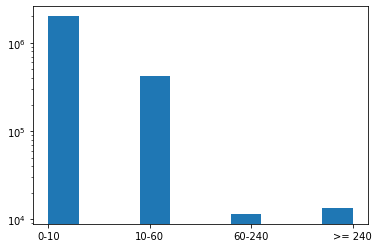

In [40]:
errors = abs(predictions - y)
errors.describe()

def classify_error(x):
    if 0 < x < 10:
        return "0-10"
    elif 10 <= x < 60:
        return "10-60"
    elif 60 <= x < 240:
        return "60-240"
    else:
        return ">= 240"

error_discription = errors.apply(lambda x: classify_error(x))

plt.hist(error_discription)
plt.yscale('log')
plt.show()

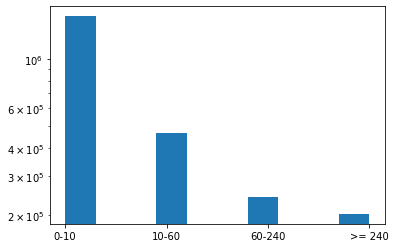

In [49]:
y_description = abs(y).apply(lambda x: classify_error(x))

plt.hist(y_description)
plt.yscale('log')
plt.show()